In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import package_DBR
import package_grp_Trio
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_grp_Trio import leadLag, PID_RT, actionP, actionI, actionD, IMCTuning
from importlib import reload
package_DBR = reload(package_DBR)
package_grp_Trio = reload(package_grp_Trio)


from datetime import datetime
import tclab
import time
from IPython.display import display, clear_output
import os

import csv



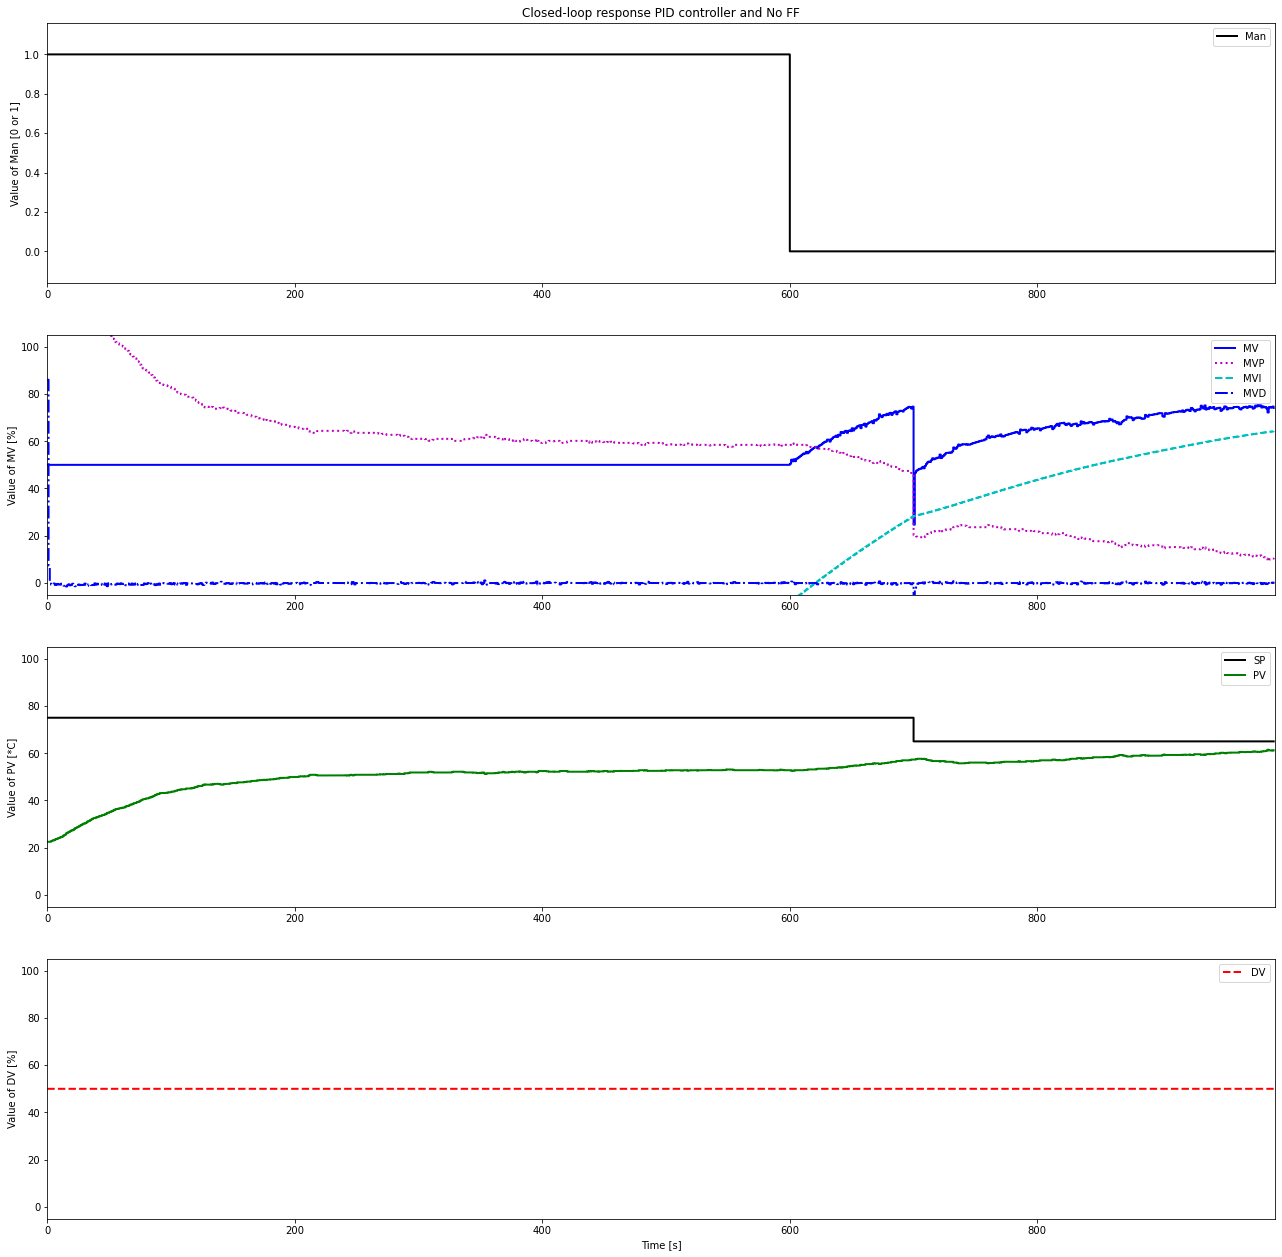

SerialException: WriteFile failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

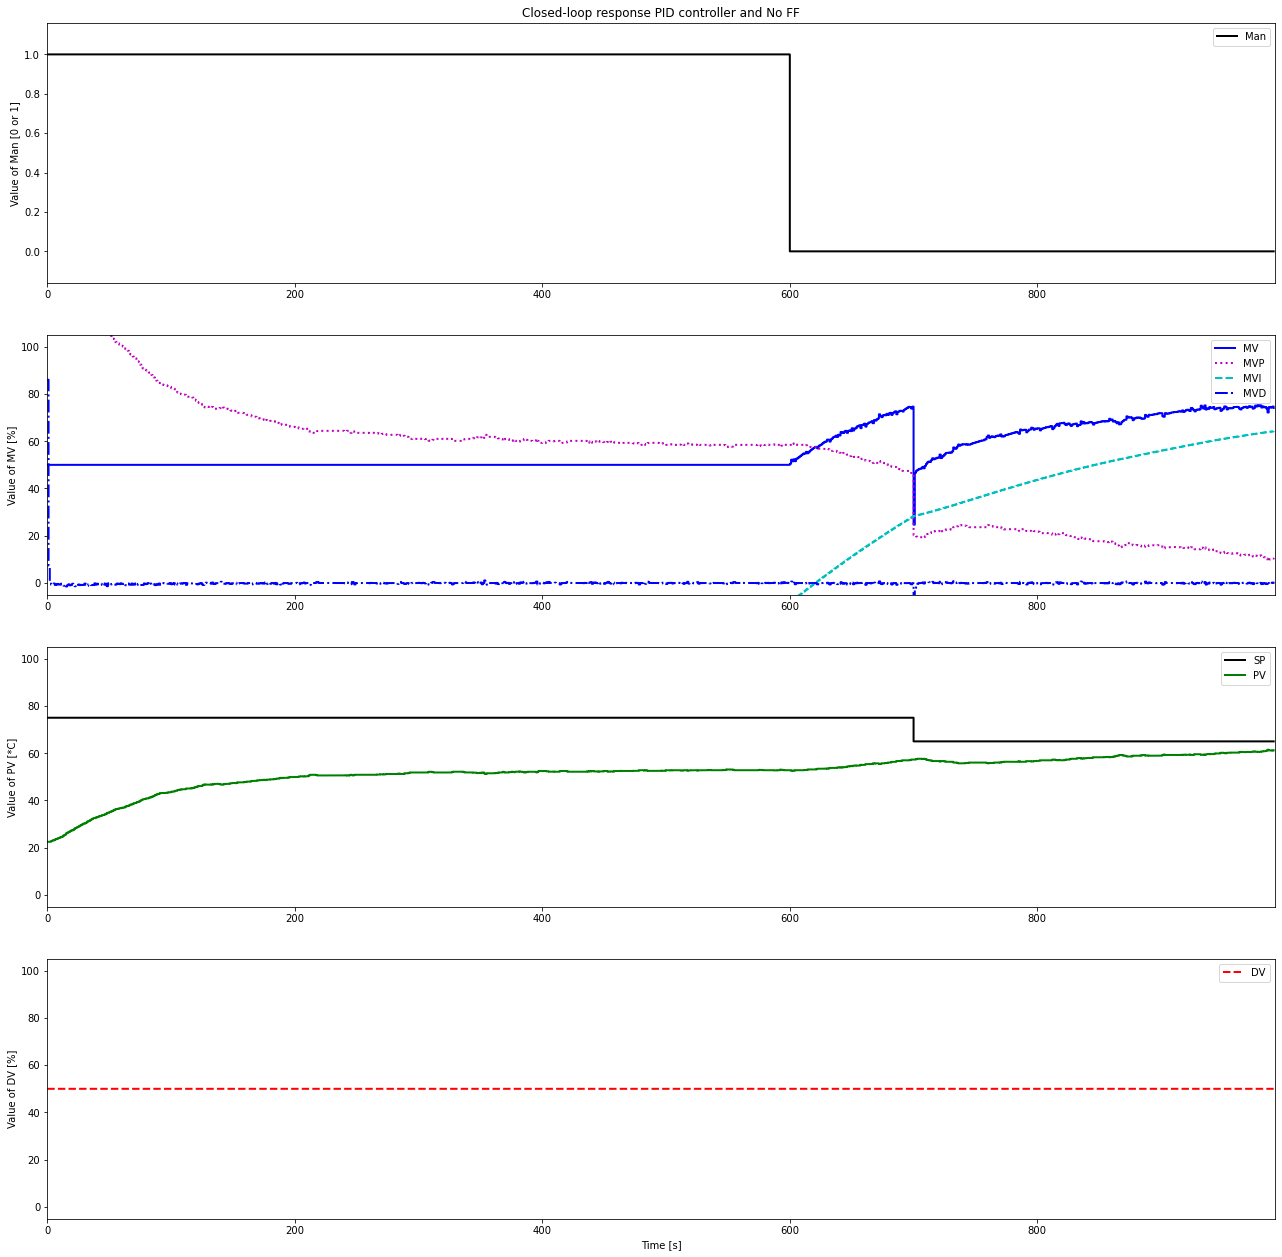

In [3]:
TSim = 1900
Ts = 1
N = int(TSim/Ts) + 1

filename =  "Closed_loop_PID_FF.csv"
header= ["t","MV","MVP","MVI","MVD","SP","PV","DV","Man"]

#working point
MV0 = 50
DV0 = 50
PV0 = 75

#Parameters for input-output dynamics
Kp = 0.63
T1p = 146.0
T2p = 1.0
thetap = 1.0

#Parameters for disturbance dynamics
Kd = 0.41
T1d = 153.0
T2d = 16.0
thetad = 10.0

#Parameters for PID controller
gamma = 0.6
Kc, Ti, Td = IMCTuning(Kp, T1p, T2p, thetap, gamma, "SOPDT")
print(Kc, Ti,Td)
alpha = 0.6
MVMin = 0
MVMax = 100
"""
#Scenario 1: OLP + no FF
ManPath = {0: True, TSim: True}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, TSim :PV0}
DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
ActivateFF = False
ManFF = True  
"""
""" 
#Scenario 2: OLP + FF
ManPath = {0: True, TSim: True}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, TSim :PV0}
DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
ActivateFF = True
ManFF = True
""" 
"""
#Scenario 3: CLP + no FF
ManPath = {0: True, 750: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, 800: PV0-10, TSim :PV0-10}
DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
ActivateFF = False
ManFF = False 
"""
#Scenario 4 : CLP + FF
ManPath = {0:True, 600:False, TSim: False}
MVManPath = {0:MV0, TSim:MV0}
SPPath = {0:PV0, 700: PV0-10, TSim: PV0-10}
DVPath = {0:DV0, 1300: DV0+10, TSim: DV0+10}
ActivateFF = True
ManFF = False 

t = []
SP = []
MV = []
PV = []
DV =[]
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = [] 
E  = []

MVFFDelay = []
MVFFLL1 = []

lab = tclab.TCLab()
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[-0.1,1.1],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title("Closed-loop response PID controller and No FF")
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[0,100],'b-',linewidth=2,label='MV',where='post')
l3, = ax2.step([0,TSim],[0,100],'m:',linewidth=2,label='MVP',where='post')
l4, = ax2.step([0,TSim],[0,100],'c--',linewidth=2,label='MVI',where='post')
l5, = ax2.step([0,TSim],[0,100],'b-.',linewidth=2,label='MVD',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l6, = ax3.step([0,TSim],[0,100],'k-',linewidth=2,label='SP',where='post')
l7, = ax3.step([0,TSim],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [*C]')
ax3.legend(loc='best')

l8, = ax4.step([0,TSim],[0,100],'r--',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')

for i in range(0,N):
    t.append(i*Ts)

    #Process value
    PV.append(lab.T1)

    #Input signals SP and DV
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)

    #Apply DV
    lab.Q2(DV[-1])

    #Feedforward
    Delay_RT(DV-DV0*np.ones_like(DV), np.max([thetad-thetap,0]), Ts, MVFFDelay)
    leadLag(MVFFDelay, -Kd/Kp, T1p,T1d, Ts, MVFFLL1)
    if ActivateFF:
        leadLag(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else: 
        leadLag(MVFFLL1, 0, T2p, T2d, Ts, MVFF)
    
    #PID controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    #PID control action
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)

    #Apply MV
    lab.Q1(MV[-1])

    #Wait for sampling period Ts
    time.sleep(Ts)

    l1.set_data(t,Man)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,SP)
    l7.set_data(t,PV)
    l8.set_data(t,DV)

    clear_output(wait=True)

    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    display(fig)

lab.close()

#Save plot
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%H%M")

ax1.set_ylim(-0.1,1.1)
ax2.set_title('Closed-loop response PID controller and Feedforward')
ax2.set_ylim(myRound(np.min((np.min(MV), np.min(MVP), np.min(MVI), np.min(MVD))),5)-5, myRound(np.max((np.max(MV), np.max(MVP), np.max(MVI), np.max(MVI), np.max(MVD))),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV), np.min(SP))),5)-5, myRound(np.max((np.max(PV), np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)

nameFile = 'Plots/Closed_loop_experiment_with_PID_and_FF' + date_time

data = [t,MV,MVP,MVI,MVD,SP,PV,DV,Man]
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file) # 2. create a csvwriter object
    csvwriter.writerow(header) # 4. write the header
    csvwriter.writerows(data) # 5. write the rest of the data

if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)   

